In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
df = pd.read_csv("HousingData.csv")
print("shape:", df.shape)
display(df.head())

shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [7]:
print(df.info())
print(df.isnull().sum().sort_values(ascending=False))   # missing counts
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
CRIM       20
ZN         20
INDUS      20
CHAS       20
LSTAT      20
AGE        20
RM          0
NOX         0
RAD         0
DIS         0
TAX         0
PTRATIO     0
B           0
MEDV        0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
CRIM,486.0,3.611874,8.720192,0.00632,0.081900,0.253715,3.560263,88.9762
ZN,486.0,11.211934,23.388876,0.00000,0.000000,0.000000,12.500000,100.0000
INDUS,486.0,11.083992,6.835896,0.46000,5.190000,9.690000,18.100000,27.7400
CHAS,486.0,0.069959,0.255340,0.00000,0.000000,0.000000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.538000,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.208500,6.623500,8.7800
AGE,486.0,68.518519,27.999513,2.90000,45.175000,76.800000,93.975000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.207450,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.000000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.000000,666.000000,711.0000


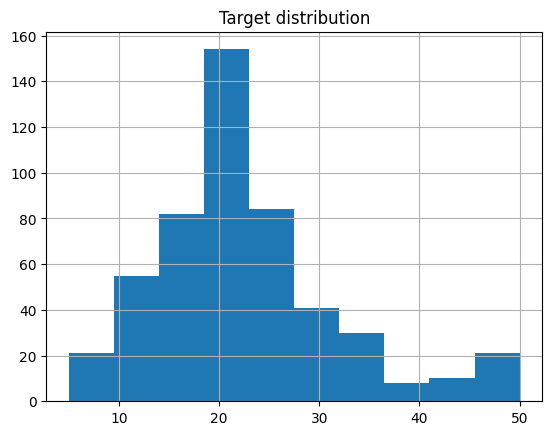

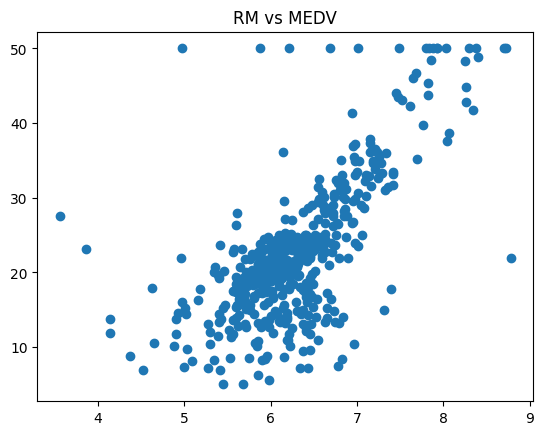

In [8]:
plt.figure(); df['MEDV'].hist(); plt.title('Target distribution'); plt.show()
if 'RM' in df.columns:
    plt.figure(); plt.scatter(df['RM'], df['MEDV']); plt.title('RM vs MEDV'); plt.show()


In [9]:
target_col = 'MEDV' if 'MEDV' in df.columns else df.columns[-1]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols: num_cols.remove(target_col)
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numeric transformer
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
transformers = []
if len(num_cols) > 0:
    transformers.append(('num', numeric_transformer, num_cols))
if len(cat_cols) > 0:
    transformers.append(('cat', categorical_transformer, cat_cols))

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')


In [12]:
X = df.drop(columns=[target_col])
y = df[target_col]

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
}

results = []
for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    # r2 and neg MSE (convert to RMSE)
    r2_scores = cross_val_score(pipe, X, y, cv=5, scoring='r2', n_jobs=-1)
    neg_mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-neg_mse)
    results.append({
        'model': name,
        'r2_mean': np.mean(r2_scores),
        'r2_std': np.std(r2_scores),
        'rmse_mean': np.mean(rmse_scores),
        'rmse_std': np.std(rmse_scores)
    })
cv_df = pd.DataFrame(results).sort_values('r2_mean', ascending=False)
display(cv_df)

,model,r2_mean,r2_std,rmse_mean,rmse_std
3,GradientBoosting,0.693124,0.097400,4.210973,1.162552
2,RandomForest,0.629285,0.179482,4.496219,1.436018
0,LinearRegression,0.345119,0.387614,5.861518,1.826613
1,DecisionTree,0.260529,0.487884,6.063191,1.376537


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('preprocessor', preprocessor),
                 ('model', GradientBoostingRegressor(random_state=42))])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4],
    'model__subsample': [0.8, 1.0],
}
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("best params:", grid.best_params_)

best_pipeline = grid.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.8}


Test RMSE=2.7352, MAE=1.9707, R2=0.8980


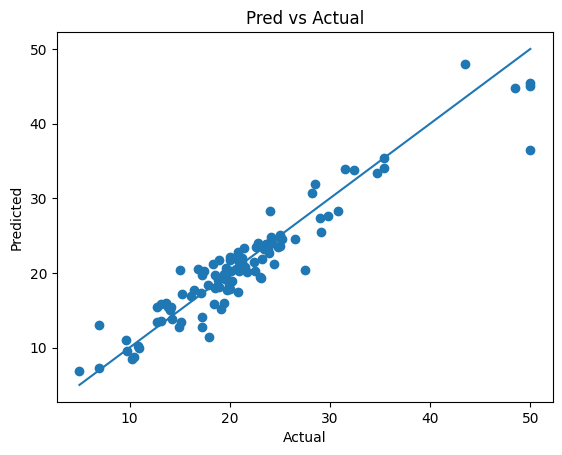

In [14]:
y_pred = best_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred); rmse = np.sqrt(mse); mae = mean_absolute_error(y_test, y_pred); r2 = r2_score(y_test, y_pred)
print(f"Test RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

plt.figure(); plt.scatter(y_test, y_pred); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Pred vs Actual'); plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()]); plt.show()

In [15]:
model = best_pipeline.named_steps['model']
if hasattr(model, 'feature_importances_'):
    # get column names after preprocessing (sklearn >=1.0)
    try:
        f_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except Exception:
        # fallback: combine numeric and OHE names if needed
        f_names = [f'f{i}' for i in range(len(model.feature_importances_))]
    fi_df = pd.DataFrame({'feature': f_names[:len(model.feature_importances_)], 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    display(fi_df.head(20))

,feature,importance
5,num__RM,0.524198
12,num__LSTAT,0.244847
7,num__DIS,0.078239
10,num__PTRATIO,0.036699
0,num__CRIM,0.033969
4,num__NOX,0.033114
9,num__TAX,0.015979
11,num__B,0.013254
6,num__AGE,0.011067
2,num__INDUS,0.003180
